
# How much can we trust a model response? Does a model handle the aerosol-forced monsoon response realistically?

The goal is to estimate model uncertainity and check if SAI creates any signal (change>uncertainty), for \
    spatial rainfall anomalies or changes \
    ITCZ deviations or shifts 
- 20260218_JJAS_NDJF_PR_BIAS.ipynb : piControl versus Historical
- 20260220_JJAS_NDJF_PR_BIAS_SSP585.ipynb : Historical versus SSP585
- 20260221_JJAS_NDJF_PR_BIAS_SSP245.ipynb : Historical versus SSP245
- 20260221_JJAS_NDJF_PR_BIAS_G6Sulfur.ipynb : Historical versus G6sulfur

In [1]:
import numpy as np
import xarray as xr
import cftime
import matplotlib as mpl
import matplotlib.pyplot as plt

Compute 

    JJAS and NDJF mean of OBS (TRMM)
    JJAS and NDJF for models : 
                                piControl, historical, SS585 bias (over historial) : bias

OBS - piControl: Tells you the model's baseline bias — how well the model simulates monsoon rainfall in the absence of any external forcing. This is the "pure" model structural error.

OBS - Historical: Tells you the model's bias in the forced climate — combining structural model error + how well the model responds to actual historical forcings.

Comparing the two: If (OBS - Historical) ≠ (OBS - piControl), it means the forcing response itself is biased — the model doesn't accurately simulate how monsoon rainfall changed due to anthropogenic/natural forcing, beyond its baseline structural errors.

In short: piControl bias = model's inherent error; Historical bias = model's inherent error + forcing response error. Their difference isolates the model's error in simulating forced monsoon changes.

piControl→Historical: Does anthropogenic forcing distort model skill? \
Historical→SSP585: Does intensified warming amplify/shift biases? \
Historical→SAI: Does cooling-based geoengineering create distinct bias patterns — i.e., does the model handle the aerosol-forced monsoon suppression realistically?


**Since all data needs to be in one grid resolution, I am regridding to 2.5x2.5 degrees**

I have 6 models:
1. Check consistency across models:
If all 6 models show similar (OBS-Historical) ≠ (OBS-piControl), it suggests a robust, systematic problem in how models respond to forcing — not a model-specific artifact.
2. Quantify the "forcing-induced bias change":
For each model, compute: **Δbias = (OBS-Historical) − (OBS-piControl)**
This isolates each model's error in simulating the forced response. Then compare Δbias across 6 models — do they agree in sign and magnitude?
3. Model ranking/weighting:
**Models where Δbias is small are better at simulating the forced monsoon response, and could be given higher weight in an ensemble for future projections.**
4. Identify inter-model spread:
If Δbias varies widely across the 6 models, it highlights uncertainty in how forcing affects monsoon — some models may overestimate, others underestimate the forced signal.
5. Bias stationarity assessment:
If a model's bias is stationary (OBS-Historical ≈ OBS-piControl), bias correction trained on historical period is more reliable for that model. Models with large Δbias violate stationarity — their bias corrections are less trustworthy for future scenarios.
This framework helps you select, weight, or flag models before using them for SAI or SSP585 projections.

I have historical from 1850-2014 and picontrol from 1850-2849 : I am planing to use 30year climatology of HIST and 30year climatology of picontrol and 30 year climatology of OBS. Now if there is a certain amount of uncertainty (standard deviation between mean of different 30 years of HIST and same for picontrol), how do I use that uncertainty information to assess Δbias?

**Setting up the uncertainty:**

- From Historical (1850–2014): You have limited non-overlapping 30-year windows (e.g., ~5 windows). Compute mean climatology for each → get spread (SD) across these means = **uncertainty in HIST climatology (σ_hist)**
- From piControl (1850–2849): You have many non-overlapping 30-year windows (~33 windows). Compute mean climatology for each → SD across these = **uncertainty in piControl climatology (σ_pi)**
- OBS is fixed (one 30-year climatology), so it has no sampling uncertainty in this framework.

**Assessing Δbias with uncertainty:**

Δbias = (OBS − HIST) − (OBS − piControl) = **piControl_mean − HIST_mean**

Uncertainty in Δbias:
**σ_Δbias = √(σ_hist² + σ_pi²)**

**Key assessment:**

- If **|Δbias| > σ_Δbias** (or use 2σ for 95% confidence): the forcing-induced bias change is **statistically significant** — the model genuinely responds differently to forcing.
- If **|Δbias| ≤ σ_Δbias**: the difference could simply be due to **internal variability**, not forcing — Δbias is not distinguishable from noise.

**Across 6 models:**
Check how many models show significant Δbias — if most do, the forced bias change is robust across the ensemble, strengthening your conclusion that:

**The model's bias is not stationary — it genuinely changes due to external forcing, beyond what internal variability alone can explain.**

Specifically, if most of the 6 models show significant Δbias, you can robustly conclude that:

- Historical forcing (anthropogenic + natural) systematically shifts model bias in simulating monsoon rainfall
- This shift is not just random internal variability — it reflects the model's **structural inability to correctly respond to forcing**
- Therefore, bias correction assuming stationarity (i.e., same bias in past and future) is **unreliable** for these models
- And by extension, projections under SSP585 or SAI from these models carry an additional layer of uncertainty beyond just spread across models

If you use multiple observational datasets (e.g., GPCP, TRMM, ERA5) for the same 30-year period, you get observational uncertainty (σ_obs) from the spread across them.
Then Δbias uncertainty becomes:
**σ_Δbias = √(σ_hist² + σ_pi² + 2·σ_obs²)**
(σ_obs appears twice because OBS enters both (OBS−HIST) and (OBS−piControl))

In [2]:
def climatology_and_uncertainty(da_year, block_size=30):
    """
    da_year: DataArray with dimension 'year'
    Returns:
        clim_mean  : mean climatology (mean of 30-yr block means)
        clim_sd    : std dev across 30-yr block means
        block_means: DataArray of each 30-yr mean
    """

    n_years = da_year.sizes["year"]
    n_blocks = n_years // block_size

    # Trim excess years
    da_trim = da_year.isel(year=slice(0, n_blocks * block_size))

    # Create block index
    block = xr.DataArray(
        np.repeat(np.arange(n_blocks), block_size),
        dims="year",
        coords={"year": da_trim.year},
        name="block"
    )

    # Compute 30-year means
    block_means = (
        da_trim
        .groupby(block)
        .mean(dim="year")*86400
    )

    # Climatological mean (mean of 30-year means)
    clim_mean = block_means.mean(dim="block")

    # Spread across 30-year climatologies
    clim_sd = block_means.std(dim="block")

    return clim_mean, clim_sd, block_means

In [3]:
import xarray as xr
from pathlib import Path

In [4]:
import sys
import os

analysis_path = os.path.abspath("../20260112_Basic_Analysis")
sys.path.append(analysis_path)

import myfunctions as mf

In [5]:
# =========================
# User-defined metadata
# =========================

varname = "pr"
varname_T = "tas"

# =========================
# Base CEDA paths
# =========================

CEDA_BASE = Path("/badc/cmip6/data/CMIP6")

In [6]:
#Model Names
MODELS = {
    "UKESM1-0-LL":  {"institution": "MOHC",         "ensemble": "r1i1p1f2",  "grid": "gn",},
    "CNRM-ESM2-1":  {"institution": "CNRM-CERFACS", "ensemble": "r1i1p1f2",  "grid": "gr",},
    "MPI-ESM1-2-LR":{"institution": "MPI-M",        "ensemble": "r1i1p1f1",  "grid": "gn",},
    "CESM2-WACCM":  {"institution": "NCAR",         "ensemble": "r1i1p1f1",  "grid": "gn",},
    "IPSL-CM6A-LR": {"institution": "IPSL",         "ensemble": "r1i1p1f1",  "grid": "gr",},
}


In [7]:
#Experiment details
EXPERIMENTS = {
    # "piControl":     {"project": "CMIP",        "scenario": "piControl",  "color": "black"},
    "HIST":          {"project": "CMIP",        "scenario": "historical", "color": "black"},
    "SSP245":        {"project": "ScenarioMIP", "scenario": "ssp245"},
    # "SSP585":        {"project": "ScenarioMIP", "scenario": "ssp585"},
    # "G6solar":       {"project": "GeoMIP",      "scenario": "G6solar"},
    # "G6sulfur":      {"project": "GeoMIP",      "scenario": "G6sulfur"},
}

In [8]:
import numpy as np

def global_mean(da):
    weights = np.cos(np.deg2rad(da.lat))
    return da.weighted(weights).mean(('lat', 'lon'))

In [9]:

all_results = {}

for model_name, model_meta in MODELS.items():

    var = {}
    var_T={}
    var_T_mean={}
    var_by_year = {}

    # ----------------------------
    # 1) LOAD DATA FOR A MODEL : ALL EXPERIMENTS
    # ----------------------------
    for exp, meta in EXPERIMENTS.items():
        # if exp not in ["SSP245", "G6sulfur", "G6solar", "piControl"]:
        #     continue

        # open dataset
        # --- special-case ensemble override ---
        if model_name == "CESM2-WACCM":
            if meta["scenario"] == "G6sulfur":
                ensemble = "r1i1p1f2"
            else:
                ensemble = "r1i1p1f1"
        else:
            ensemble = model_meta["ensemble"]


        base = (
            CEDA_BASE
            / meta["project"]
            / model_meta["institution"]
            / model_name
            / meta["scenario"]
            / ensemble
            / "Amon"
            / varname
            / model_meta["grid"]
            / "latest"
        )

        base_T = (
            CEDA_BASE
            / meta["project"]
            / model_meta["institution"]
            / model_name
            / meta["scenario"]
            / ensemble
            / "Amon"
            / varname_T
            / model_meta["grid"]
            / "latest"
        )

        ######## ds for PR ############
        print(str(base))
        # ds = mf.open_files(str(base))
        if model_name == "CESM2-WACCM":
            if meta["scenario"] == "G6sulfur":
                ds = mf.open_files_CESM_G6sulfur(base)
            elif meta["scenario"] == "ssp585":
                ds = mf.open_files_CESM_ssp585(base)
            else:
                ds = mf.open_files(str(base))
        elif model_name == "IPSL-CM6A-LR":
            if meta["scenario"] == "ssp585":
                ds = mf.open_files_IPSL_ssp585(base)
            else:
                ds = mf.open_files(str(base))
        else:
            ds = mf.open_files(str(base))
        ###############################

        ######## ds for T ############
        print(str(base_T))
        # ds = mf.open_files(str(base))
        if model_name == "CESM2-WACCM":
            if meta["scenario"] == "G6sulfur":
                ds_T = mf.open_files_CESM_G6sulfur(base_T)
            elif meta["scenario"] == "ssp585":
                ds_T = mf.open_files_CESM_ssp585(base_T)
            else:
                ds_T = mf.open_files(str(base_T))
        elif model_name == "IPSL-CM6A-LR":
            if meta["scenario"] == "ssp585":
                ds_T = mf.open_files_IPSL_ssp585(base_T)
            else:
                ds_T = mf.open_files(str(base_T))
        else:
            ds_T = mf.open_files(str(base_T))
        ###############################

        
        # ds = ...
        var[exp] = mf.read_var(ds, varname)
        
        # if exp not in ["SSP585"]:
        #     continue
        var_T[exp] = mf.read_var(ds_T, varname_T)

    # ----------------------------
    # 2) SEASONAL MEANS BY YEAR
    # ----------------------------
    for exp, da in var.items():
        var_by_year[exp] = {
            "SUM": mf.seasonal_mean_by_year_old(da, 6, 9),
            "WIN": mf.seasonal_mean_by_year_old(da, 11, 2)
        }
        
    for exp, da in var_T.items():    
        # if exp not in ["SSP585"]:
        #     continue
        var_T_mean[exp] = {
            "ANN": mf.climatological_mean(da, 1, 12)
        }
    
    
    # ----------------------------
    # 3) 30-YR CLIMATOLOGY
    # ----------------------------
    results = {}
    
    for exp in var_by_year:
    
        results[exp] = {}
    
        for season in ["SUM", "WIN"]:
    
            da_year = var_by_year[exp][season]
    
            clim_mean, clim_sd, block_means = climatology_and_uncertainty(da_year)
    
            results[exp][season] = {
                "mean": clim_mean,
                "sd": clim_sd,
                "blocks": block_means
            }

    # ----------------------------
    # 4) Δbias (AFTER results built)
    # ----------------------------
    if "SSP245" in results and "HIST" in results:

        delta = {}
        delta_sd = {}

        delta_T = float(
            global_mean(var_T_mean["SSP245"]["ANN"]).compute() - 
            global_mean(var_T_mean["HIST"]["ANN"]).compute()
        )
        print(f"ΔT (SSP245 - HIST) = {delta_T:.3f} K")

        
        for season in ["SUM", "WIN"]:

            mean_ssp = results["SSP245"][season]["mean"] 
            mean_hist = results["HIST"][season]["mean"]
    
            sd_ssp = results["SSP245"][season]["sd"]
            sd_hist = results["HIST"][season]["sd"]
    
            delta[season] = ( mean_ssp - mean_hist ) / delta_T
    
            delta_sd[season] = np.sqrt(sd_ssp**2 + sd_hist**2)
    
        results["delta_bias"] = delta
        results["delta_bias_sd"] = delta_sd
        
    # Save results for models:
    all_results[model_name] = results

/badc/cmip6/data/CMIP6/CMIP/MOHC/UKESM1-0-LL/historical/r1i1p1f2/Amon/pr/gn/latest
/badc/cmip6/data/CMIP6/CMIP/MOHC/UKESM1-0-LL/historical/r1i1p1f2/Amon/tas/gn/latest
/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp245/r1i1p1f2/Amon/pr/gn/latest
/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp245/r1i1p1f2/Amon/tas/gn/latest
ΔT (SSP245 - HIST) = 2.819 K
/badc/cmip6/data/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/historical/r1i1p1f2/Amon/pr/gr/latest
/badc/cmip6/data/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/historical/r1i1p1f2/Amon/tas/gr/latest
/badc/cmip6/data/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM-ESM2-1/ssp245/r1i1p1f2/Amon/pr/gr/latest
/badc/cmip6/data/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM-ESM2-1/ssp245/r1i1p1f2/Amon/tas/gr/latest
ΔT (SSP245 - HIST) = 2.008 K
/badc/cmip6/data/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/historical/r1i1p1f1/Amon/pr/gn/latest
/badc/cmip6/data/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/historical/r1i1p1f1/Amon/tas/gn/latest
/badc/cmip6/data/CMIP6/ScenarioMIP/MPI-M/MPI-ESM1-2-LR/ss

/apps/jasmin/jaspy/miniforge_envs/jaspy3.12/mf3-25.3.0-3/envs/jaspy3.12-mf3-25.3.0-3-v20250704/lib/python3.12/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'pr' has multiple fill values {np.float32(1e+20), np.float64(1e+20)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/apps/jasmin/jaspy/miniforge_envs/jaspy3.12/mf3-25.3.0-3/envs/jaspy3.12-mf3-25.3.0-3-v20250704/lib/python3.12/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'tas' has multiple fill values {np.float32(1e+20), np.float64(1e+20)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/apps/jasmin/jaspy/miniforge_envs/jaspy3.12/mf3-25.3.0-3/envs/jaspy3.12-mf3-25.3.0-3-v20250704/lib/python3.12/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'pr' has multiple fill values {np.float32(1e+20), np.float64(1e+20)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/apps/jasmin/jaspy/minif

/badc/cmip6/data/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp245/r1i1p1f1/Amon/tas/gn/latest


/apps/jasmin/jaspy/miniforge_envs/jaspy3.12/mf3-25.3.0-3/envs/jaspy3.12-mf3-25.3.0-3-v20250704/lib/python3.12/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'tas' has multiple fill values {np.float32(1e+20), np.float64(1e+20)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


ΔT (SSP245 - HIST) = 2.238 K
/badc/cmip6/data/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/Amon/pr/gr/latest
/badc/cmip6/data/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/Amon/tas/gr/latest
/badc/cmip6/data/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR/ssp245/r1i1p1f1/Amon/pr/gr/latest
/badc/cmip6/data/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR/ssp245/r1i1p1f1/Amon/tas/gr/latest
ΔT (SSP245 - HIST) = 2.402 K


In [10]:
print("results",results)

results {'HIST': {'SUM': {'mean': <xarray.DataArray 'pr' (lat: 143, lon: 144)> Size: 82kB
dask.array<mean_agg-aggregate, shape=(143, 144), dtype=float32, chunksize=(143, 144), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 572B -90.0 -88.73 -87.46 -86.2 ... 87.46 88.73 90.0
  * lon      (lon) float32 576B 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5, 'sd': <xarray.DataArray 'pr' (lat: 143, lon: 144)> Size: 82kB
dask.array<_sqrt, shape=(143, 144), dtype=float32, chunksize=(143, 144), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 572B -90.0 -88.73 -87.46 -86.2 ... 87.46 88.73 90.0
  * lon      (lon) float32 576B 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5, 'blocks': <xarray.DataArray 'pr' (block: 5, lat: 143, lon: 144)> Size: 412kB
dask.array<mul, shape=(5, 143, 144), dtype=float32, chunksize=(1, 143, 144), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 572B -90.0 -88.73 -87.46 -86.2 ... 87.46 88.73 90.0
  * lon      (lon) f

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

def plot_delta_bias(results, season='SUM', model_name='Model'):
    """
    Plot delta_bias, |delta_bias|, sigma_delta_bias, and significance mask
    """
    delta_bias = results['delta_bias'][season].compute()
    sigma = results['delta_bias_sd'][season].compute()
    
    # Significance mask: where |Δbias| > σ_Δbias (2*sigma for 95%)
    significant = np.abs(delta_bias) > sigma
    
    lat = delta_bias.lat
    lon = delta_bias.lon
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5),
                              subplot_kw={'projection': ccrs.PlateCarree()})

    for ax in axes:
        ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()], crs=ccrs.PlateCarree())
    
    titles = [
        f'$\\Delta$bias$_{{SSP245-HIST}}$ ({season})',
        f'$\\sigma_{{\\Delta bias}}$ - |$\\Delta$bias| ({season})',
        f'$\\sigma_{{\\Delta bias}}$ ({season})'
    ]
    data_list = [delta_bias, sigma-np.abs(delta_bias), sigma]
    
    # Colormaps
    # cmaps = ['RdBu_r', 'Reds', 'Oranges'] ;#different colormaps
    cmaps = ['RdBu_r', 'RdBu_r', 'RdBu_r'] ;#same colormap because I am using same vmax-vmin
    
    
    for i, (ax, data, title, cmap) in enumerate(zip(axes, data_list, titles, cmaps)):
        ax.add_feature(cfeature.COASTLINE, linewidth=0.3)
        # ax.add_feature(cfeature.BORDERS, linewidth=0.3)

        #-----------------------------
        # symmetric colorbar for Δbias
        #-----------------------------

        #------Using pcolormesh--------
        # if i == 0:
        #     vmax = float(np.nanpercentile(np.abs(data.values), 95))
        #     norm = mcolors.TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)
        #     im = ax.pcolormesh(lon, lat, data, cmap=cmap, norm=norm,
        #                        transform=ccrs.PlateCarree())
        # else:
        #     vmax = float(np.nanpercentile(data.values, 95))
        #     im = ax.pcolormesh(lon, lat, data, cmap=cmap, vmin=0, vmax=vmax,
        #                        transform=ccrs.PlateCarree())

        #------Using contourf--------

        #-----------------------------
        # commenting the bellow block
        # using symmetric colorbar for all plots vmax=0.5, vmin=-0.5
        #-----------------------------
        # if i == 0:
        #     vmax = float(np.nanpercentile(np.abs(data.values), 95))
        #     levels = np.linspace(-vmax, vmax, 21)
        #     im = ax.contourf(lon, lat, data, levels=levels, cmap=cmap,
        #                      extend='both', transform=ccrs.PlateCarree())
        # else:
        #     vmax = float(np.nanpercentile(data.values, 95))
        #     levels = np.linspace(0, vmax, 21)
        #     im = ax.contourf(lon, lat, data, levels=levels, cmap=cmap,
        #                      extend='max', transform=ccrs.PlateCarree())
        vmax=0.75
        vmin=-vmax
        levels = np.linspace(vmin, vmax, 11)
        im = ax.contourf(lon, lat, data, levels=levels, cmap=cmap,
                         extend='both', transform=ccrs.PlateCarree())
        
        # Stipple where significant (only on Δbias and |Δbias| panels)
        if i in [0, 1]:
            sig_lat, sig_lon = np.where(significant.values)
            ax.scatter(lon.values[sig_lon], lat.values[sig_lat],
                      s=1.5, c='lime', alpha=1.0, transform=ccrs.PlateCarree())
        
        plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.05,
                    label='mm/day' if 'units' not in str(data) else 'kg m⁻² s⁻¹')
        ax.set_title(title, fontsize=12)
        # ax.set_global()
        ax.set_extent([float(lon.min()), float(lon.max()), 
               float(lat.min()), float(lat.max())], crs=ccrs.PlateCarree())
        ax.set_aspect('auto')

        ax.set_xticks(np.arange(np.floor(lon.min()), np.ceil(lon.max())+1, 30), crs=ccrs.PlateCarree(180))
        ax.set_yticks(np.arange(np.floor(lat.min()), np.ceil(lat.max())+1, 10), crs=ccrs.PlateCarree(180))
        ax.xaxis.set_major_formatter(LongitudeFormatter())
        ax.yaxis.set_major_formatter(LatitudeFormatter())
        ax.tick_params(labelsize=8)
    
    plt.suptitle(f'{model_name} — Forcing-induced bias change', fontsize=14, y=1.02)
    plt.tight_layout()
    # plt.savefig(f'delta_bias_{season}_{model_name}.png', dpi=150, bbox_inches='tight')
    plt.show()



In [12]:
def compute_results(all_results, lat_slice=None, lon_slice=None):
    """
    Optionally subset and compute all dask arrays in all_results dict (all models).
    
    Parameters:
    -----------
    all_results : dict of {model_name: results_dict} with dask arrays
    lat_slice : tuple e.g. (-30, 30) or None for global
    lon_slice : tuple e.g. (60, 100) or None
    
    Returns:
    --------
    all_results_computed : dict of {model_name: computed results}
    """
    import dask

    def subset(da):
        if lat_slice is not None:
            da = da.sel(lat=slice(*lat_slice))
        if lon_slice is not None:
            da = da.sel(lon=slice(*lon_slice))
        return da

    lazy_all = {}
    for model_name, results in all_results.items():
        lazy_all[model_name] = {
            'SSP245': {
                'SUM': {'mean': subset(results['SSP245']['SUM']['mean']),
                        'sd':   subset(results['SSP245']['SUM']['sd'])},
                'WIN': {'mean': subset(results['SSP245']['WIN']['mean']),
                        'sd':   subset(results['SSP245']['WIN']['sd'])}
            },
            'HIST': {
                'SUM': {'mean': subset(results['HIST']['SUM']['mean']),
                        'sd':   subset(results['HIST']['SUM']['sd'])},
                'WIN': {'mean': subset(results['HIST']['WIN']['mean']),
                        'sd':   subset(results['HIST']['WIN']['sd'])}
            },
            'delta_bias':    {'SUM': subset(results['delta_bias']['SUM']),
                              'WIN': subset(results['delta_bias']['WIN'])},
            'delta_bias_sd': {'SUM': subset(results['delta_bias_sd']['SUM']),
                              'WIN': subset(results['delta_bias_sd']['WIN'])}
        }

    return dask.compute(lazy_all)[0]


# # Usage
# all_results_tropics = compute_results(all_results, lat_slice=(-50, 50))
# all_results_SA      = compute_results(all_results, lat_slice=(5, 40), lon_slice=(60, 100))
# all_results_global  = compute_results(all_results)

# # Then plot per model
# for model_name, results in all_results_tropics.items():
#     plot_delta_bias(results, season='SUM', model_name=model_name)

In [13]:
# Slice for tropics
trop_lat=30
all_results_tropics  = compute_results(all_results, lat_slice=(-trop_lat, trop_lat))


What each panel shows:

Δbias: Sign tells you direction — positive means piControl wetter than Historical (relative to obs) \
|Δbias|: Magnitude of forcing-induced bias change regardless of direction \
σ_Δbias: Where uncertainty is large (high internal variability) \
Stippling: Where |Δbias| > σ_Δbias — i.e., the forcing-induced bias change is statistically significant beyond internal variability

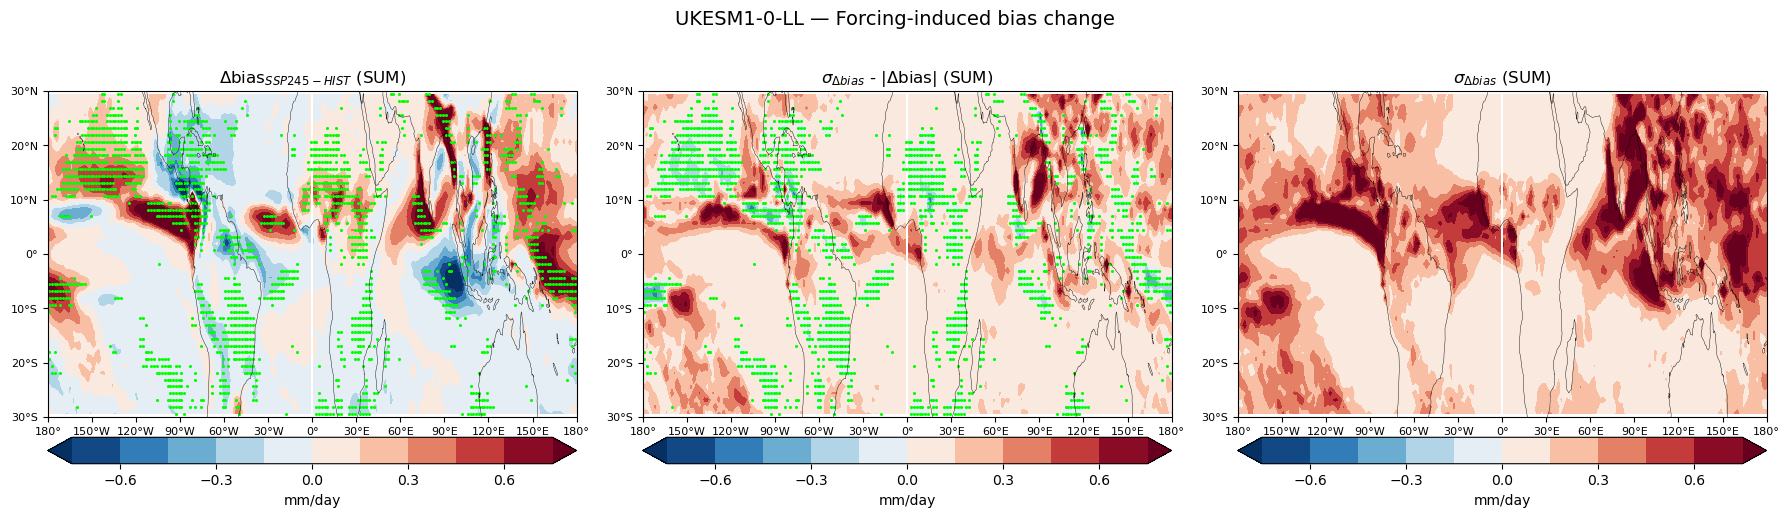

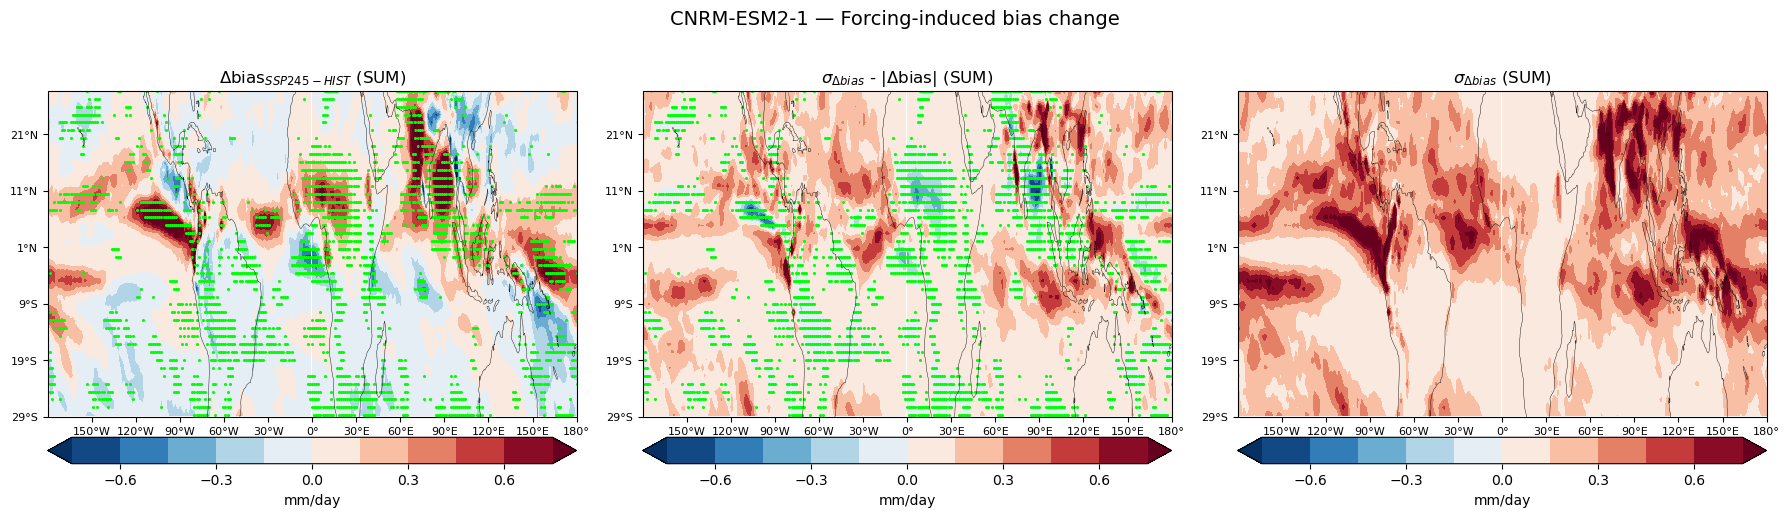

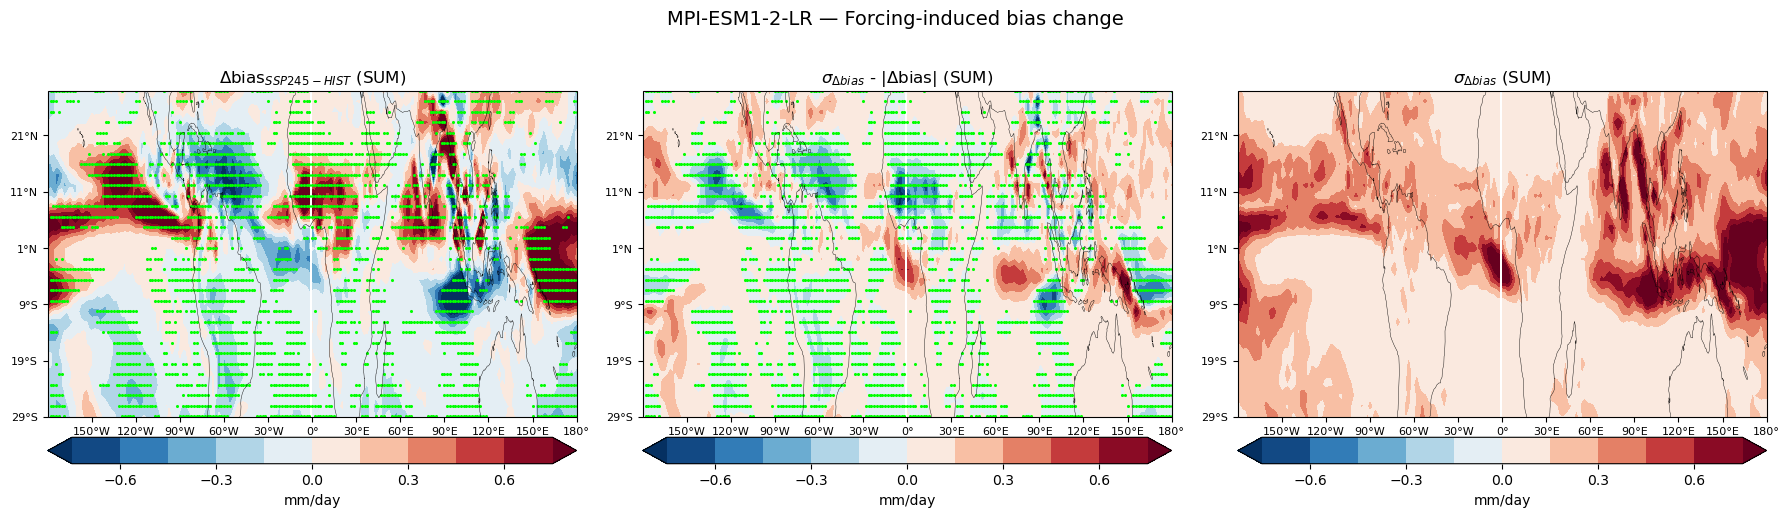

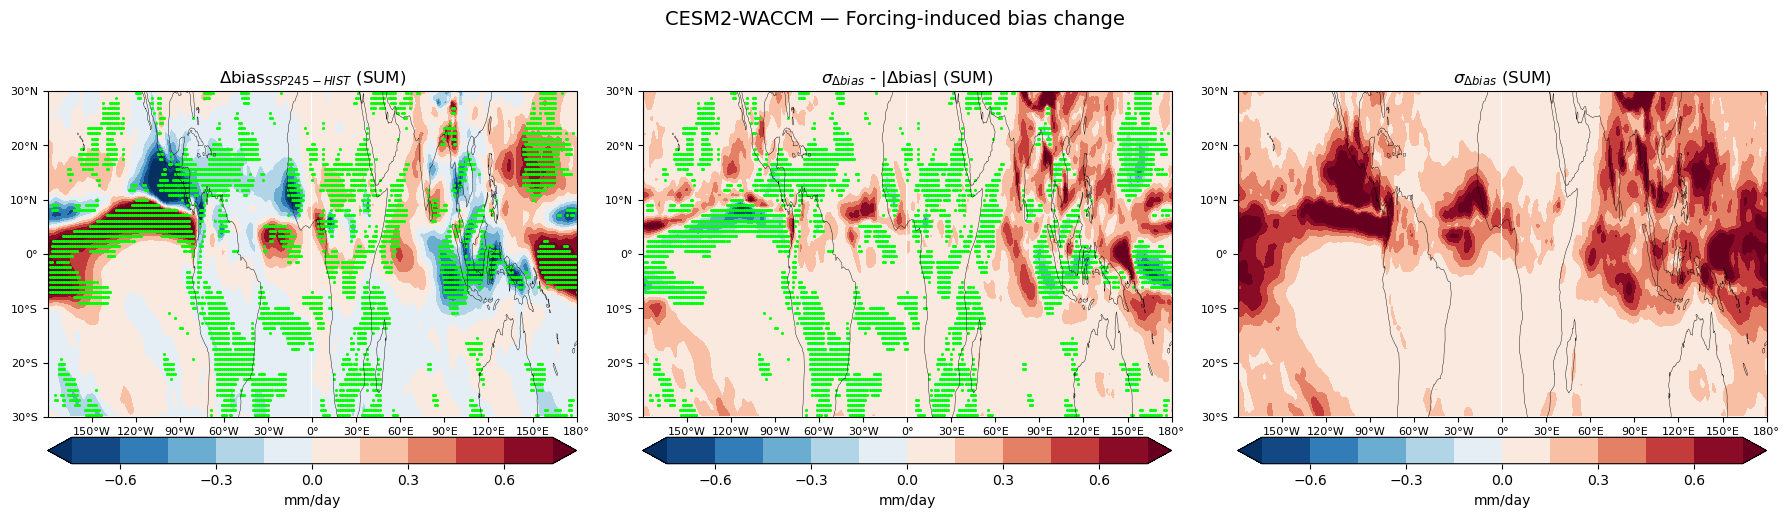

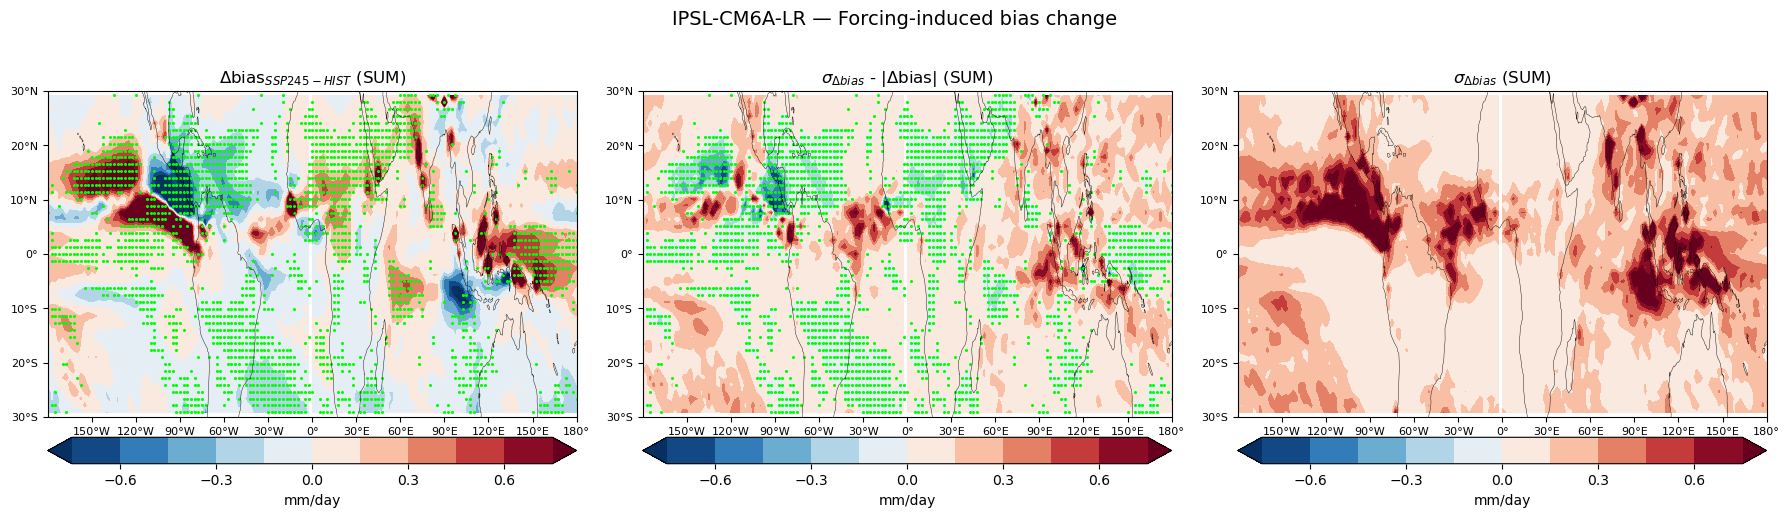

In [14]:
# Plot per model for summar
for model_name, results in all_results_tropics.items():
    plot_delta_bias(results, season='SUM', model_name=model_name)

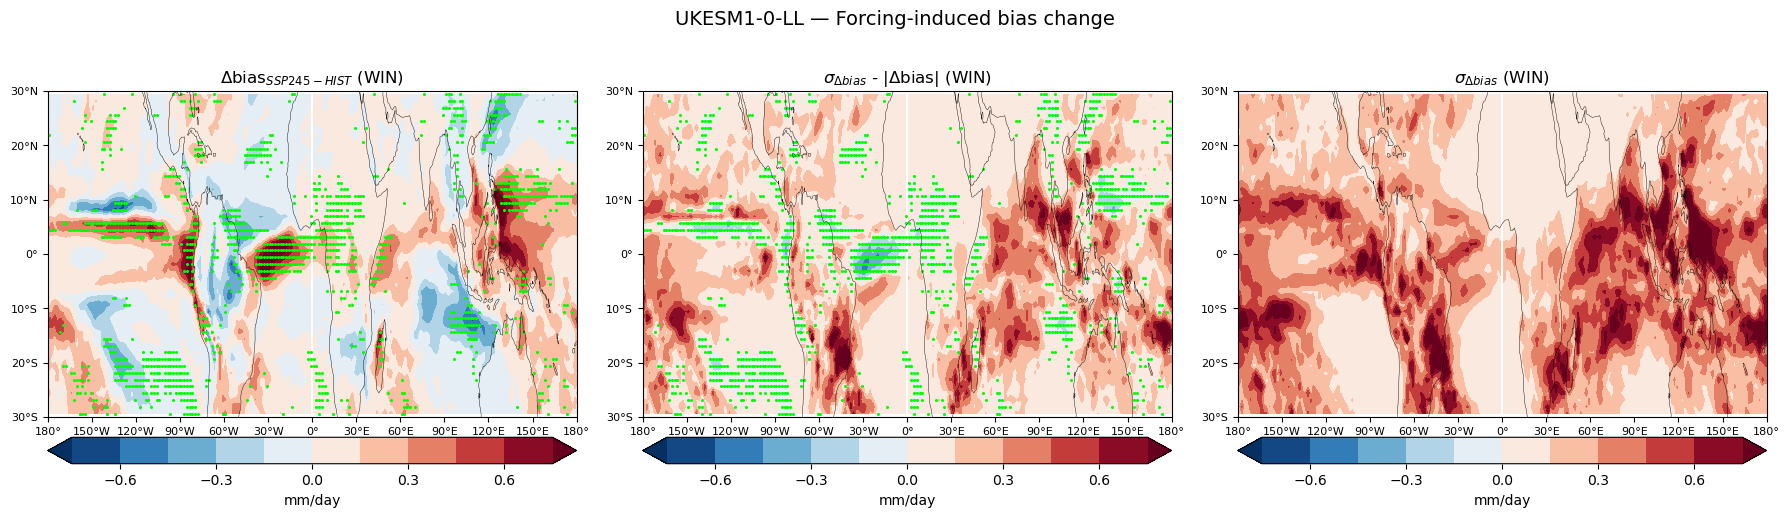

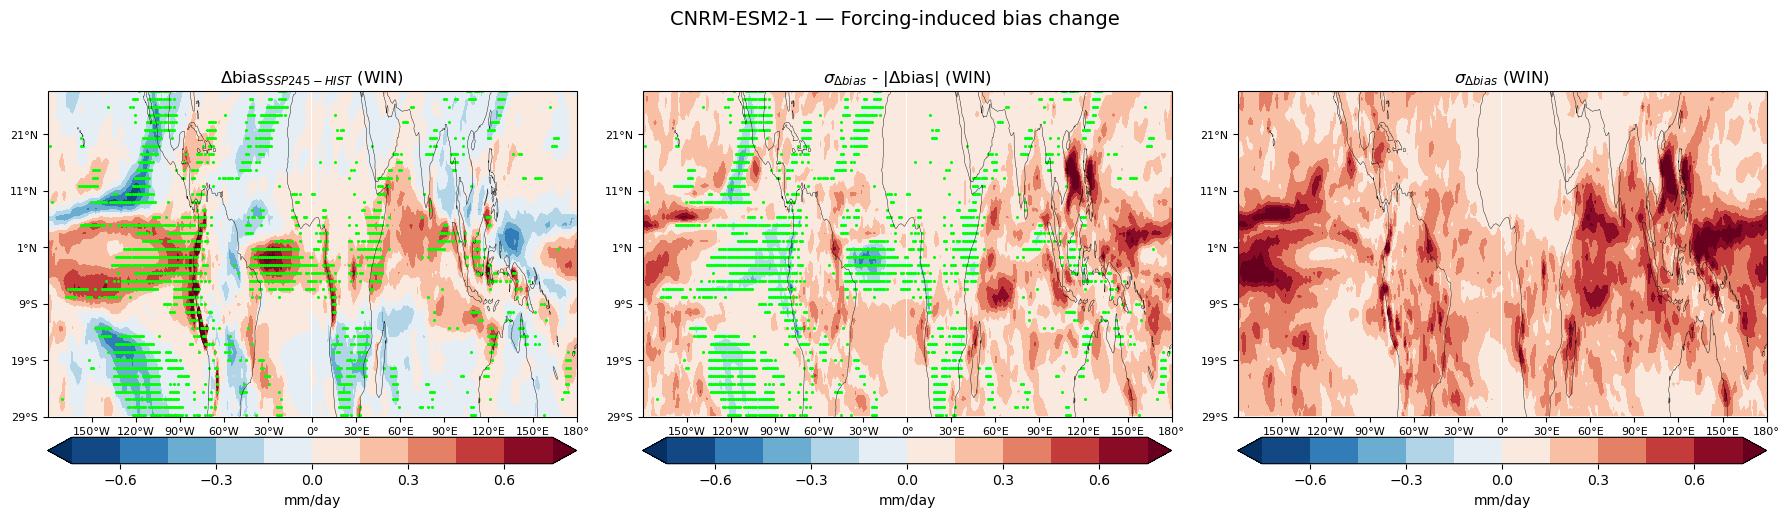

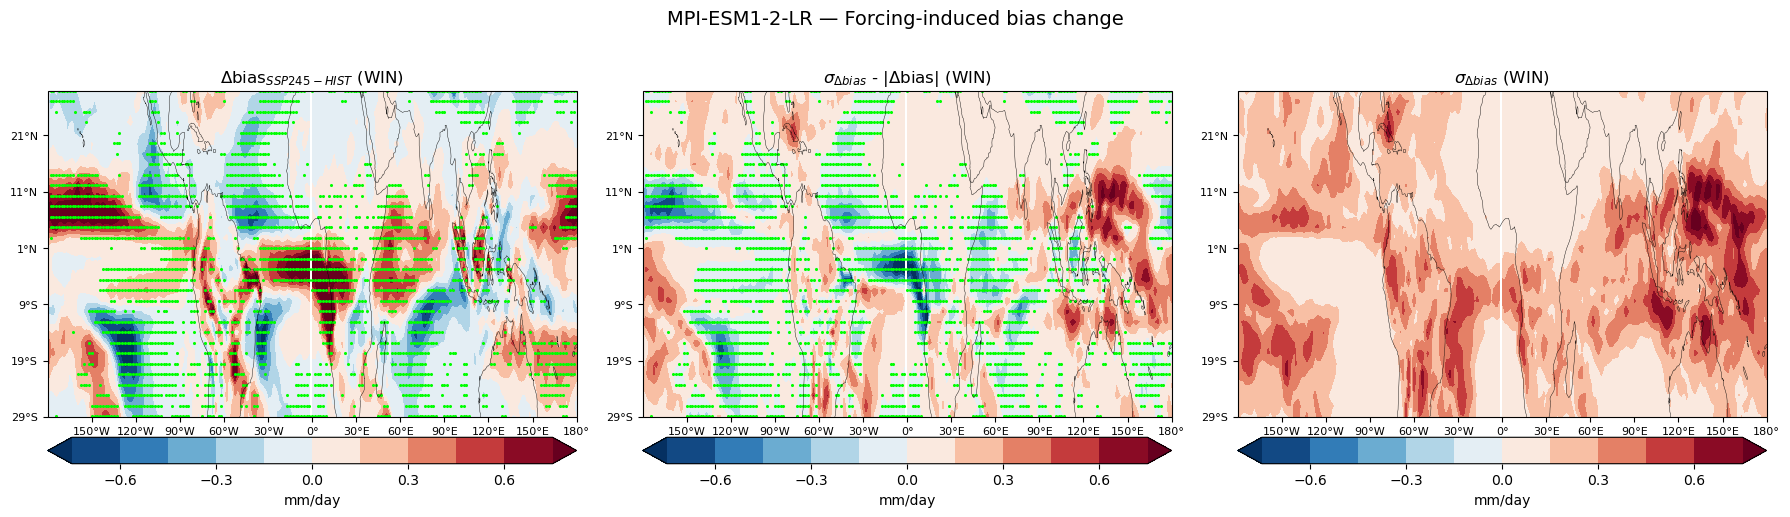

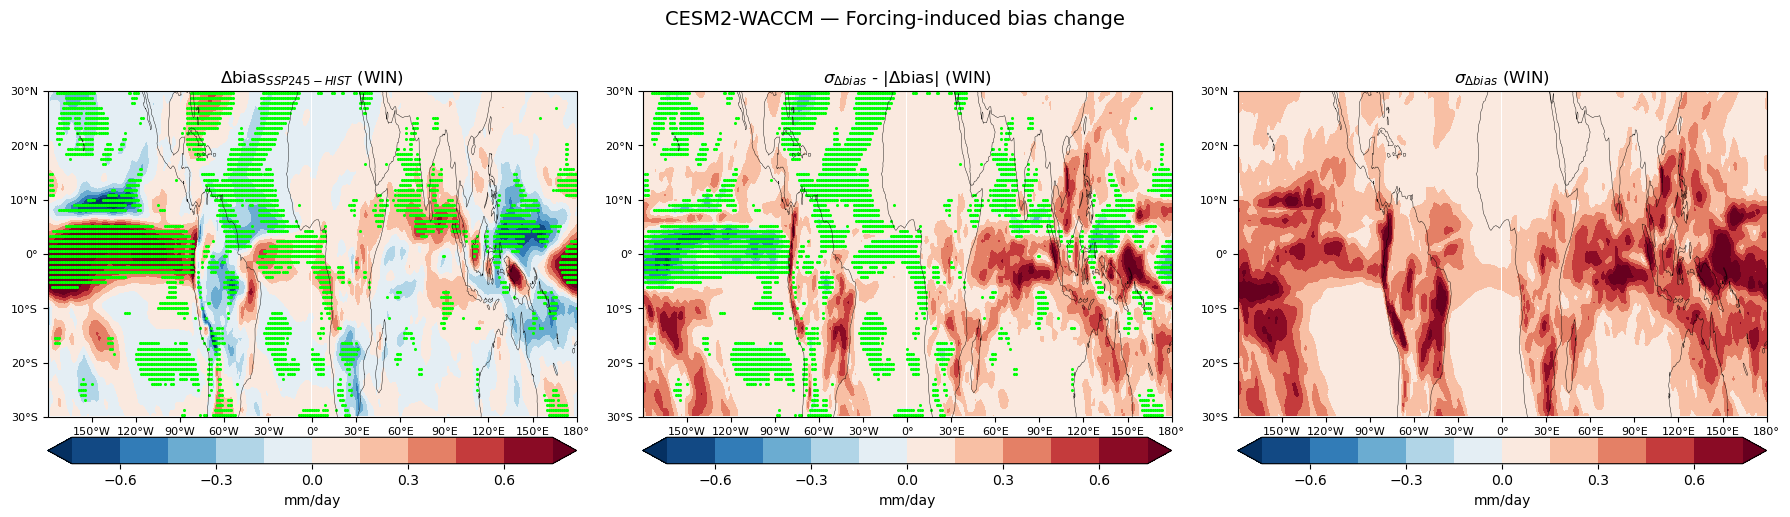

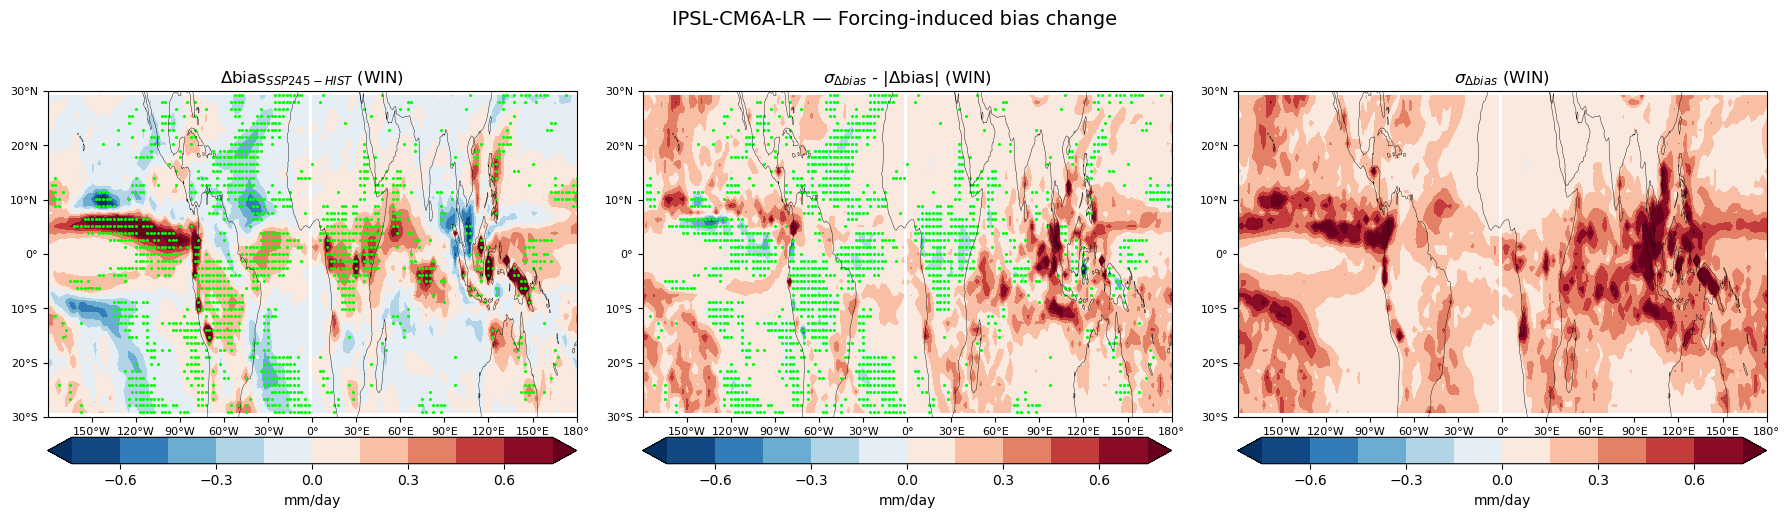

In [15]:
# Plot per model for Winter
for model_name, results in all_results_tropics.items():
    plot_delta_bias(results, season='WIN', model_name=model_name)

|Δbias| > σ_Δbias : I get very less stippling for this condition ... it means :
- models exhibit stable behavior and errors do not amplify due to external forcing : GOOD
- However the above is not entirely true because I see that my model internal variability is so large (dominated by 33 30-year samples of PiControl) that it masks any real forcing-induced bias change. Notice from middle coloumn panels that, my sigma (internal variability) os large everywhere than bias (bias=HIST=PiCtrl=model response to external forcing)

How much of it changes for SSP585? For example:

- I see more stiplling ... meaning, SSP585 aplifies model bias (response)
- I still see from middle coloumn panels that, my sigma (internal variability: computed as SD of SSP585 and HIST) is large everywhere than bias. How many blocks of SSP585 are there?

# Benchmark piControl or Historical ?
I am essentially trying to see the following by different pairs of comparisions:
piControl→Historical: Does anthropogenic forcing distort model skill?
Historical→SSP585: Does intensified warming amplify/shift biases?
Historical→SAI: Does cooling-based geoengineering create distinct bias patterns

Should I instead do:
piControl→Historical
piControl→SSP585
piControl→SAI
?

Great question. It depends on what you want to isolate:

**Your original framework (HIST as baseline):**
- piControl→HIST: effect of historical forcing on bias
- HIST→SSP585: *additional* effect of future warming on bias
- HIST→SAI: *additional* effect of SAI on bias
- **Advantage:** SSP585 and SAI are directly comparable to each other relative to the same baseline (HIST), which is the natural reference for future scenarios

**piControl as common baseline:**
- piControl→HIST: effect of historical forcing
- piControl→SSP585: *total* effect of all forcing (historical + future warming)
- piControl→SAI: *total* effect of all forcing (historical + SAI)
- **Advantage:** common unforced reference for all comparisons

**Recommendation: Your original framework is better for your purpose** because:

1. SSP585 and SAI both branch from the end of HIST — so HIST is the natural physical baseline
2. Comparing SSP585 vs SAI bias changes *relative to HIST* directly answers "does SAI create different bias patterns than warming?" 
3. piControl→SSP585 conflates historical and future forcing effects, making it harder to attribute where bias changes originate
4. ΔT normalization for SSP585 and SAI is also more meaningful relative to HIST than piControl

So keep HIST as the reference for future scenarios, and piControl→HIST as a separate diagnostic.

In [16]:
trop_lat

30

In [25]:
import xesmf as xe
import xarray as xr
import numpy as np

def regrid_to_common(da, target_lat=None, target_lon=None):
    """Regrid a DataArray to common lat/lon grid."""
    if target_lat is None:
        target_lat = np.arange(-50, 51, 2.5)
    elif isinstance(target_lat, tuple):
        target_lat = np.arange(target_lat[0], target_lat[1]+1, 2.5)
    elif isinstance(target_lat, (int, float)):
        target_lat = np.arange(-target_lat, target_lat+1, 2.5)

    if target_lon is None:
        target_lon = np.arange(0, 360, 2.5)  # always default to full lon
    elif isinstance(target_lon, tuple):
        target_lon = np.arange(target_lon[0], target_lon[1]+1, 2.5)

    ds_out = xr.Dataset({
        'lat': (['lat'], target_lat),
        'lon': (['lon'], target_lon)
    })

    ds_in = da.to_dataset(name='data')
    regridder = xe.Regridder(ds_in, ds_out, method='bilinear', reuse_weights=False)
    return regridder(da) 


def plot_multimodel_delta_bias(all_results_tropics, trop_bound=trop_lat, season='SUM', agree_threshold=4):
    """
    Multi-model mean delta_bias with stippling where models agree on sign.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

    # Stack delta_bias across models
    delta_list = []
    for model_name, results in all_results_tropics.items():
        if 'delta_bias' in results:
            da = results['delta_bias'][season]
            da_regridded = regrid_to_common(da, target_lat=trop_bound)  # regrid before stacking
            delta_list.append(da_regridded)
            print(f"{model_name}: regridded to {da_regridded.shape}")

    n_models = len(delta_list)  # ADD THIS LINE
    print(f"Number of models: {n_models}")
    
    # Concat
    stacked = xr.concat(delta_list, dim='model')
    mm_mean = stacked.mean('model')

    # Agreement: count models with positive sign, negative sign
    n_positive = (stacked > 0).sum('model')
    n_negative = (stacked < 0).sum('model')

    # Stipple where at least agree_threshold models agree on same sign
    agreement = (n_positive >= agree_threshold) | (n_negative >= agree_threshold)

    lat = mm_mean.lat
    lon = mm_mean.lon

    fig, ax = plt.subplots(1, 1, figsize=(10, 5),
                           subplot_kw={'projection': ccrs.PlateCarree(180)})

    ax.add_feature(cfeature.COASTLINE, linewidth=0.3)

    vmax = 0.5 ;#float(np.nanpercentile(np.abs(mm_mean.values), 95))
    levels = np.linspace(-vmax, vmax, 21)
    im = ax.contourf(lon, lat, mm_mean, levels=levels, cmap='RdBu_r',
                     extend='both', transform=ccrs.PlateCarree())

    # Stipple where models agree
    sig_lat, sig_lon = np.where(agreement.values)
    ax.scatter(lon.values[sig_lon], lat.values[sig_lat],
               s=0.5, c='k', alpha=0.5, transform=ccrs.PlateCarree())

    ax.set_extent([float(lon.min()), float(lon.max()),
                   float(lat.min()), float(lat.max())], crs=ccrs.PlateCarree())
    ax.set_aspect('auto')

    ax.set_xticks(np.arange(np.floor(float(lon.min())),
                            np.ceil(float(lon.max()))+1, 30), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(np.floor(float(lat.min())),
                            np.ceil(float(lat.max()))+1, 10), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.tick_params(labelsize=8)

    plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.05,shrink=1.0,aspect=40,
                 label='$\\Delta$bias / $\\Delta$T (mm day$^{-1}$ K$^{-1}$)')

    ax.set_title(
        f'Multi-model mean $\\Delta$bias$_{{SSP245-HIST}}$ ({season})\n'
        f'Stippling: ≥{agree_threshold}/{n_models} models agree on sign',
        fontsize=12
    )

    plt.tight_layout()
    # plt.savefig(f'multimodel_delta_bias_{season}.png', dpi=150, bbox_inches='tight')
    plt.show()

# # Usage
# plot_multimodel_delta_bias(all_results_tropics, season='SUM', agree_threshold=4)
# plot_multimodel_delta_bias(all_results_tropics, season='WIN', agree_threshold=4)

UKESM1-0-LL: regridded to (25, 144)
CNRM-ESM2-1: regridded to (25, 144)
MPI-ESM1-2-LR: regridded to (25, 144)
CESM2-WACCM: regridded to (25, 144)
IPSL-CM6A-LR: regridded to (25, 144)
Number of models: 5


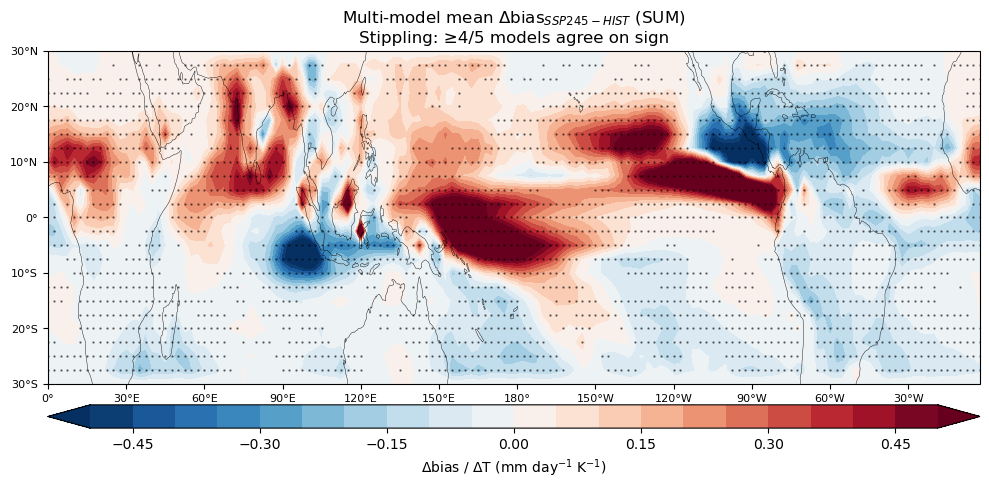

In [26]:
# Summar
plot_multimodel_delta_bias(all_results_tropics, trop_bound=trop_lat, season='SUM', agree_threshold=4)


UKESM1-0-LL: regridded to (25, 144)
CNRM-ESM2-1: regridded to (25, 144)
MPI-ESM1-2-LR: regridded to (25, 144)
CESM2-WACCM: regridded to (25, 144)
IPSL-CM6A-LR: regridded to (25, 144)
Number of models: 5


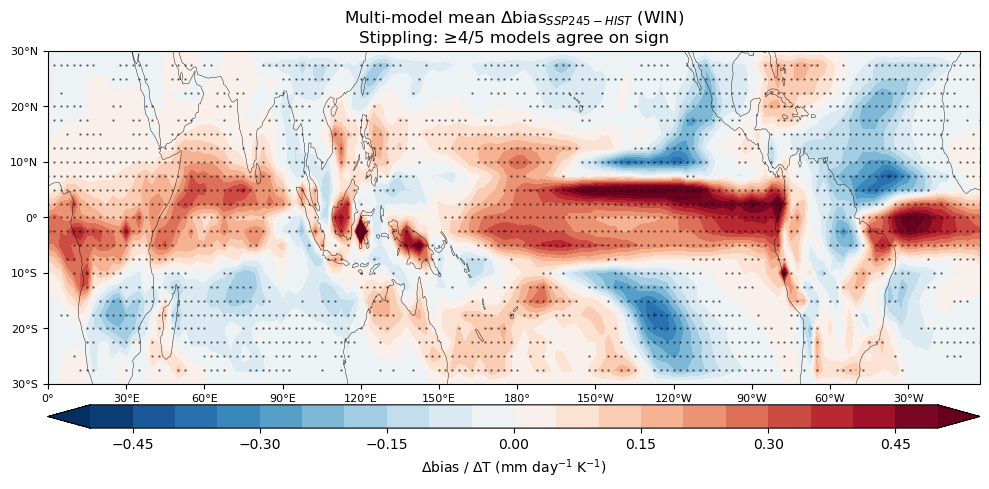

In [27]:
# Winter
plot_multimodel_delta_bias(all_results_tropics, trop_bound=trop_lat, season='WIN', agree_threshold=4)
